In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
import geopandas as gpd
from shapely.wkt import loads
from pyproj import Proj, Transformer
from tqdm import tqdm

In [3]:

def lat_lon_to_axis(lat, lon, axis_direction=(1, 0), crs="EPSG:3857"):
    """
    Convert latitude and longitude to a one-dimensional value in meters along an axis.

    Args:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        axis_direction (tuple): Direction vector of the axis (x, y).
        crs (str): CRS for projecting to meters (default: EPSG:3857).

    Returns:
        float: One-dimensional projection value in meters.
    """
    
    # Define the transformer for projecting lat/lon to the desired CRS
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    
    # Project the latitude and longitude to meters
    x, y = transformer.transform(lon, lat)
    
    # Normalize the axis direction vector
    axis_vector = np.array(axis_direction)
    axis_unit_vector = axis_vector / np.linalg.norm(axis_vector)
    
    # Compute the projection of the point onto the axis
    projection_value = np.dot([x, y], axis_unit_vector)
    return projection_value

def find_traffic_light_id(row, segments_gdf):
    """
    Find the nearest segment ID to a given row in a DataFrame.

    Args:
        row (pd.Series): Row in a DataFrame with columns 'lat' and 'lon'.
        segments_gdf (gpd.GeoDataFrame): GeoDataFrame with segment geometries.

    Returns:
        int: ID of the nearest segment.
    """
    # Create a GeoDataFrame for the point
    point = gpd.GeoDataFrame(
        geometry=[loads(f"POINT ({row['lat']} {row['lon']})")], crs="EPSG:4326" # Make sure lat and lon is given completely right! Lat first then lon
    )
    
    # Reproject both point and segments to a projected CRS for accurate distance calculations
    projected_crs = "EPSG:4326"  # Common projected CRS for distance calculations
    point_proj = point.to_crs(projected_crs)
    segments_gdf_proj = segments_gdf.to_crs(projected_crs)
    max_distance = float("inf")
    nearest_link_id = None
    for index, row in segments_gdf_proj.iterrows():
        distance = row.geometry.distance(point_proj.geometry[0])
        if distance < max_distance:
            max_distance = distance
            nearest_link_id = index
    return nearest_link_id


In [4]:
# loading the main dataframe
main_df = pd.read_csv("data_cell_80s.csv")
# loading the traffic light states
with open("20181024_d1_0830_0900_traffic_light_states.json") as f:
    traffic_info = json.load(f)
# loading the segments
segments_gdf = gpd.read_file("20181024_d1_0830_0900_traffic_lights_segments.csv")
# Convert to GeoDataFrame
if "geometry" in segments_gdf.columns:
    # Convert 'geometry' to shapely objects if needed
    segments_gdf["geometry"] = segments_gdf["geometry"].apply(loads)
    # Create GeoDataFrame and set the CRS to WGS 84 (latitude/longitude)
    segments_gdf = gpd.GeoDataFrame(segments_gdf, geometry="geometry", crs="EPSG:4326")
else:
    raise ValueError("The DataFrame does not have a 'geometry' column.")

# Reproject to a projected CRS (replace EPSG code with appropriate UTM zone)
segments_gdf = segments_gdf.to_crs("EPSG:25832")  # Example for UTM Zone 32N

# Calculate lengths
segments_gdf["length"] = segments_gdf.geometry.length
segments_gdf = segments_gdf.to_crs("EPSG:4326")  # Example for UTM Zone 32N

lon_one_axis_trajectory = []
lat_one_axis_trajectory = []
for i, row in segments_gdf.iterrows():
    lat_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[0][1], row.geometry.coords.xy[0][0], crs="EPSG:4326"))
    lon_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[1][1], row.geometry.coords.xy[1][0], crs="EPSG:4326"))

segments_gdf["lon_one_axis_trajectory"] = lon_one_axis_trajectory
segments_gdf["lat_one_axis_trajectory"] = lat_one_axis_trajectory

# Calculate total length
total_length = segments_gdf["length"].sum()

# loading the traffic lights
traffic_lights_df = pd.read_csv("traffic_lights.csv")
# find traffic light segment id
traffic_lights_df["nearest_link_id"] = traffic_lights_df.apply(find_traffic_light_id, axis=1, segments_gdf=segments_gdf)
traffic_lights_df = traffic_lights_df.iloc[:5, :]
# loading the traffic light states
with open("traffic_info_dict.pkl", "rb") as f:
    traffic_lights_dict_states = pickle.load(f)

# TEMPORARY CODE

In [5]:
# loading the main dataframe
main_df = pd.read_csv("data_cell_80s.csv")
# loading the traffic light states
with open("20181024_d1_0830_0900_traffic_light_states.json") as f:
    traffic_info = json.load(f)
# loading the segments
segments_gdf = gpd.read_file("20181024_d1_0830_0900_traffic_lights_segments.csv")
# Convert to GeoDataFrame
if "geometry" in segments_gdf.columns:
    # Convert 'geometry' to shapely objects if needed
    segments_gdf["geometry"] = segments_gdf["geometry"].apply(loads)
    # Create GeoDataFrame and set the CRS to WGS 84 (latitude/longitude)
    segments_gdf = gpd.GeoDataFrame(segments_gdf, geometry="geometry", crs="EPSG:4326")
else:
    raise ValueError("The DataFrame does not have a 'geometry' column.")

# Reproject to a projected CRS (replace EPSG code with appropriate UTM zone)
segments_gdf = segments_gdf.to_crs("EPSG:25832")  # Example for UTM Zone 32N

# Calculate lengths
segments_gdf["length"] = segments_gdf.geometry.length
segments_gdf = segments_gdf.to_crs("EPSG:4326")  # Example for UTM Zone 32N

lon_one_axis_trajectory = []
lat_one_axis_trajectory = []
for i, row in segments_gdf.iterrows():
    lat_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[0][1], row.geometry.coords.xy[0][0], crs="EPSG:4326"))
    lon_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[1][1], row.geometry.coords.xy[1][0], crs="EPSG:4326"))

segments_gdf["lon_one_axis_trajectory"] = lon_one_axis_trajectory
segments_gdf["lat_one_axis_trajectory"] = lat_one_axis_trajectory

# Calculate total length
total_length = segments_gdf["length"].sum()

# loading the traffic lights
traffic_lights_df = pd.read_csv("traffic_lights.csv")
# find traffic light segment id
traffic_lights_df["nearest_link_id"] = traffic_lights_df.apply(find_traffic_light_id, axis=1, segments_gdf=segments_gdf)
traffic_lights_df = traffic_lights_df.iloc[:5, :]
# loading the traffic light states
with open("traffic_info_dict.pkl", "rb") as f:
    traffic_lights_dict_states = pickle.load(f)

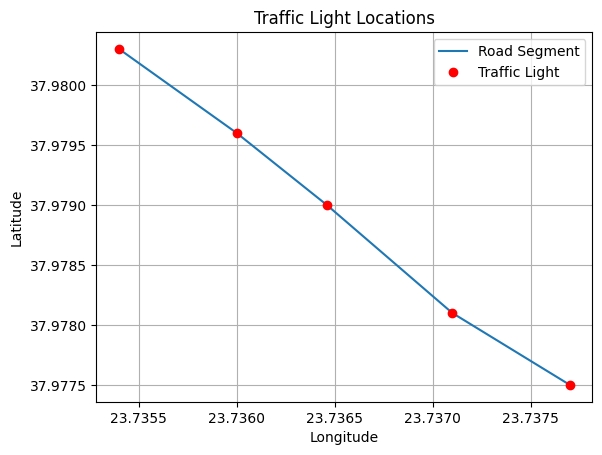

In [6]:
plt.plot(segments_gdf["lon_one_axis_trajectory"], segments_gdf["lat_one_axis_trajectory"], "-", label="Road Segment")
plt.plot(traffic_lights_df["lon"], traffic_lights_df["lat"], "ro", label="Traffic Light")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Traffic Light Locations")
plt.legend()
plt.ticklabel_format(useOffset=False)
plt.grid()
plt.show()

# Define the constants for truncating

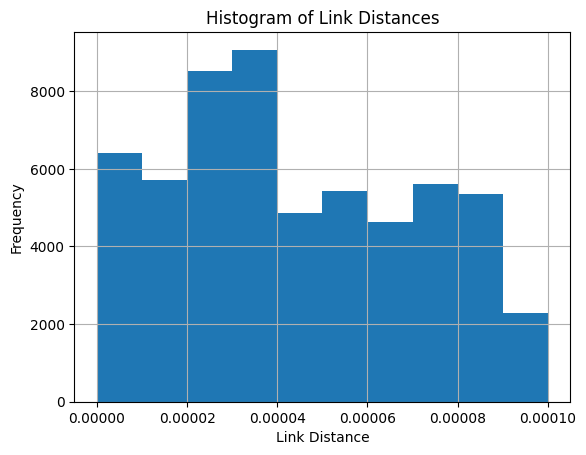

In [7]:
plt.hist(main_df["link_distance"])
plt.title("Histogram of Link Distances")
plt.xlabel("Link Distance")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [8]:
DISTANCE_THRESHOLD = 0.0001

# Normalize the one axis trajectory

In [9]:
from CTM_classic import CTMParameters, initialize_density, update_cell_status
from sklearn.preprocessing import normalize

# Initialize CTM parameters
ctm_params = CTMParameters()
ctm_params.segment_length = segments_gdf["length"].mean()
ctm_params.cell_length= 6

# Truncate points that are too far from the main corridor line
main_df_truncated = main_df[main_df["link_distance"] < DISTANCE_THRESHOLD].copy()  # Ensure it's a copy
# main_df_truncated["one_axis_trajectory"] = main_df_truncated.apply(lambda row: lat_lon_to_axis(row["lat"], row["lon"], crs="EPSG:4326"), axis=1)

# Normalize trajectory
normalized_trajectory = (
    main_df_truncated["one_axis_trajectory"] - main_df_truncated["one_axis_trajectory"].min()
)
normalized_trajectory = normalized_trajectory / normalized_trajectory.max() * segments_gdf["length"].sum()

# Assign to the DataFrame safely
main_df_truncated.loc[:, "normalized_trajectory"] = normalized_trajectory
main_df_truncated

Unnamed: 0.1  Unnamed: 0        lat        lon    speed  lon_acc  \
0             57929       95980  37.978102  23.737058   0.0000   0.0000   
1             57930       95981  37.978102  23.737058   0.0000   0.0000   
2             57931       95982  37.978102  23.737058   0.0000   0.0000   
3             57932       95983  37.978102  23.737058   0.0000   0.0000   
4             57933       95984  37.978102  23.737058   0.0000   0.0000   
...             ...         ...        ...        ...      ...      ...   
57895        411763      896523  37.977561  23.737679  21.1474   1.2291   
57896        411764      896524  37.977562  23.737681  21.3298   1.3038   
57897        411765      896525  37.977562  23.737683  21.5231   1.3818   
57898        411766      896526  37.977562  23.737685  21.7271   1.4514   
57899        411767      896527  37.977562  23.737688  21.9407   1.5148   

       lat_acc    time  veh_id  link_id  link_distance  one_axis_trajectory  \
0       0.0000  360.72      63        2       0.000033         2.642397e+06   
1       0.0000  360.76      63        2       0.000033         2.642397e+06   
2       0.0000  360.80      63        2       0.000033         2.642397e+06   
3       0.0000  360.84      63        2       0.000033         2.642397e+06   
4       0.0000  360.88      63        2       0.000033         2.642397e+06   
...        ...     ...     ...      ...            ...                  ...   
57895  -2.2775  440.52     521        3       0.000028         2.642466e+06   
57896  -2.2980  440.56     521        3       0.000030         2.642467e+06   
57897  -2.3074  440.60     521        3       0.000032         2.642467e+06   
57898  -2.3044  440.64     521        3       0.000033         2.642467e+06   
57899  -2.2907  440.68     521        3       0.000035         2.642467e+06   

       normalized_trajectory closest_cell                     veh_id_list  
0                 404.824294      cell_21  frozenset({376, 407, 387, 63})  
1                 404.824294      cell_21  frozenset({376, 407, 387, 63})  
2                 404.824294      cell_21  frozenset({376, 407, 387, 63})  
3                 404.824294      cell_21  frozenset({376, 407, 387, 63})  
4                 404.824294      cell_21  frozenset({376, 407, 387, 63})  
...                      ...          ...                             ...  
57895             547.906757      cell_15                frozenset({521})  
57896             548.367570      cell_15                frozenset({521})  
57897             548.828383      cell_15                frozenset({521})  
57898             549.289196      cell_16                frozenset({521})  
57899             549.980416      cell_16                frozenset({521})  

[57900 rows x 15 columns]

In [12]:
from shapely.geometry import LineString
# Initialize densities for each segment
segment_densities_predicted = {idx: initialize_density(ctm_params, segments_gdf.iloc[idx]["length"]) for idx in segments_gdf.index}

def divide_linestring(linestring, n):
    """
    Divides a LINESTRING into n equal parts.

    :param linestring: A Shapely LineString object
    :param n: Number of equal parts to divide into
    :return: A list of LineString objects representing the segments
    """
    if not isinstance(linestring, LineString):
        raise ValueError("Input must be a Shapely LineString")

    # Get the total length of the LineString
    total_length = linestring.length

    # Calculate the step for division
    distances = np.linspace(0, total_length, n + 1)

    # Create parts
    parts = []
    for i in range(len(distances) - 1):
        start_point = linestring.interpolate(distances[i])
        end_point = linestring.interpolate(distances[i + 1])
        parts.append(LineString([start_point, end_point]))

    return gpd.GeoSeries(parts)

cells_linestring = []
for link_id, segment in segments_gdf.iterrows():
    # Divide the segment into cells
    cells = divide_linestring(segment["geometry"], len(segment_densities_predicted[link_id])) #‌ TODO check if the length of the cells is correct
    cells_linestring.append(cells)

# Flatten the cells into a new column for each segment
segments_gdf["cells_linestring"] = cells_linestring

# If you want to ensure individual cells are separate rows, you can explode the column
segments_gdf_exploded = segments_gdf.explode("cells_linestring").reset_index().rename(columns={"index": "link_id"})


# Group by `link_id` and collect `cells_linestring` into lists
grouped = segments_gdf_exploded.groupby("link_id")["cells_linestring"].apply(list).reset_index()

# Expand the lists into separate columns
expanded = pd.DataFrame(grouped["cells_linestring"].tolist(), index=grouped["link_id"])

# Add the other columns you want to retain (e.g., `geometry`, `length`, etc.)
metadata = segments_gdf_exploded.drop_duplicates(subset="link_id").set_index("link_id")[["geometry", "length", "lon_one_axis_trajectory", "lat_one_axis_trajectory"]]
segments_gdf_exploded = metadata.join(expanded)

# Rename the columns for clarity (optional)
segments_gdf_exploded.columns = list(metadata.columns) + [f"cell_{i+1}" for i in range(expanded.shape[1])]

# Reset index for a clean DataFrame
segments_gdf_exploded = segments_gdf_exploded.reset_index()
for column in segments_gdf_exploded.columns:
    if column.startswith("cell_"):
        segments_gdf_exploded[column] = gpd.GeoSeries(segments_gdf_exploded[column])
segments_gdf_exploded.head(2)

link_id                                      geometry      length  \
0        0  LINESTRING (37.9803 23.7354, 37.9796 23.736)  108.829563   
1        1  LINESTRING (37.9796 23.736, 37.979 23.73646)   88.845240   

   lon_one_axis_trajectory  lat_one_axis_trajectory  \
0                  23.7354                  37.9803   
1                  23.7360                  37.9796   

                                            cell_1  \
0  LINESTRING (37.9803 23.7354, 37.98026 23.73543)   
1   LINESTRING (37.9796 23.736, 37.97956 23.73603)   

                                              cell_2  \
0  LINESTRING (37.98026 23.73543, 37.98022 23.73547)   
1  LINESTRING (37.97956 23.73603, 37.97951 23.73607)   

                                             cell_3  \
0  LINESTRING (37.98022 23.73547, 37.98018 23.7355)   
1  LINESTRING (37.97951 23.73607, 37.97947 23.7361)   

                                             cell_4  \
0  LINESTRING (37.98018 23.7355, 37.98014 23.73553)   
1  LINESTRING (37.97947 23.7361, 37.97943 23.73613)   

                                              cell_5  ...  \
0  LINESTRING (37.98014 23.73553, 37.98011 23.73557)  ...   
1  LINESTRING (37.97943 23.73613, 37.97939 23.73616)  ...   

                                            cell_15  \
0  LINESTRING (37.97976 23.73587, 37.97972 23.7359)   
1                                              None   

                                            cell_16  \
0  LINESTRING (37.97972 23.7359, 37.97968 23.73593)   
1                                              None   

                                             cell_17  \
0  LINESTRING (37.97968 23.73593, 37.97964 23.73597)   
1                                               None   

                                          cell_18 cell_19 cell_20 cell_21  \
0  LINESTRING (37.97964 23.73597, 37.9796 23.736)    None    None    None   
1                                            None    None    None    None   

  cell_22 cell_23 cell_24  
0    None    None    None  
1    None    None    None  

[2 rows x 29 columns]

In [13]:
len(segment_densities_predicted[1])

14

# Find the closest cell (Skip if already run)

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm  # Import tqdm for progress

def find_closest_cell(lat, lon, link_id, segments_gdf_exploded):
    """
    Find the nearest segment ID to a given point.
    
    Args:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        segments_gdf_exploded (GeoDataFrame): GeoDataFrame with segment geometries and cell data.
    
    Returns:
        str: ID of the nearest cell (e.g., 'cell_1').
    """
    # Create a GeoDataFrame for the point
    point = gpd.GeoDataFrame(
        geometry=[Point(lat, lon)], crs="EPSG:4326"
    )

    # Reproject both point and segments to a projected CRS for accurate distance calculations
    projected_crs = "EPSG:3395"  # Consider using a projected CRS suitable for distance measurements
    point_proj = point.to_crs(projected_crs)

    max_distance = float("inf")
    nearest_cell_id = None

    # Iterate through the segments and calculate distances
    for index, row in segments_gdf_exploded.iloc[[link_id]].iterrows():
        cell_columns = row.filter(regex=r'^cell_\d')  # Use raw string to avoid escape sequence warning
        if not cell_columns.empty:
            for cell_id, cell_value in cell_columns.items():
                if cell_value is None and int(cell_id.split("_")[1]) > len(segment_densities_predicted[index]):  # Skip empty cells
                    
                    continue
                # Assuming the cell_value corresponds to a geometry, e.g., a LineString or Polygon
                cell_geometry = segments_gdf_exploded.at[index, cell_id]
                # Convert to GeoSeries and reproject
                if isinstance(cell_geometry, gpd.GeoSeries):
                    cell_geometry = cell_geometry.to_crs(projected_crs)
                else:
                    cell_geometry = gpd.GeoSeries([cell_geometry], crs=segments_gdf_exploded.crs).to_crs(projected_crs).iloc[0]
                if cell_geometry and cell_geometry.is_valid:  # Ensure the geometry is valid
                    # Calculate the distance from the point to the cell geometry
                    distance = point_proj.distance(cell_geometry)

                    # Check if distance is scalar (just in case it's returned as a Series)
                    if isinstance(distance, (float, int)):  # Ensure it's a scalar
                        if distance < max_distance:
                            max_distance = distance
                            nearest_cell_id = cell_id  # Capture the ID of the nearest cell
                    else:
                        # Handle the case where distance is a Series or other unexpected result
                        distance = distance.item()  # Convert to scalar if it's a Series
                        if distance < max_distance:
                            max_distance = distance
                            nearest_cell_id = cell_id

    return nearest_cell_id

main_df_truncated_with_cell = main_df_truncated.copy()

main_df_truncated_with_cell["closest_cell"] = [
    find_closest_cell(row["lat"], row["lon"], int(row["link_id"]), segments_gdf_exploded) 
    for _, row in tqdm(main_df_truncated_with_cell.iterrows(), total=len(main_df_truncated_with_cell), desc="Processing Rows")
]

# print(f"The nearest cell IDs are: {main_df_truncated_with_cell['closest_cell']}")

main_df_truncated_with_cell.to_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_cell.csv")

In [16]:
main_df_truncated_with_cell

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0        lat        lon    speed  \
0                 0         57929       95980  37.978102  23.737058   0.0000   
1              4803        300487      651653  37.978130  23.737118   0.0000   
2             10319        326398      682574  37.978162  23.737146   0.0000   
3             16775        340390      723014  37.978138  23.737139   0.0000   
4                 1         57930       95981  37.978102  23.737058   0.0000   
...             ...           ...         ...        ...        ...      ...   
57895         57895        411763      896523  37.977561  23.737679  21.1474   
57896         57896        411764      896524  37.977562  23.737681  21.3298   
57897         57897        411765      896525  37.977562  23.737683  21.5231   
57898         57898        411766      896526  37.977562  23.737685  21.7271   
57899         57899        411767      896527  37.977562  23.737688  21.9407   

       lon_acc  lat_acc    time  veh_id  link_id  link_distance  \
0       0.0000   0.0000  360.72      63        2       0.000033   
1       0.0000   0.0000  360.72     376        2       0.000032   
2       0.0000   0.0000  360.72     387        2       0.000073   
3       0.0000   0.0000  360.72     407        2       0.000054   
4       0.0000   0.0000  360.76      63        2       0.000033   
...        ...      ...     ...     ...      ...            ...   
57895   1.2291  -2.2775  440.52     521        3       0.000028   
57896   1.3038  -2.2980  440.56     521        3       0.000030   
57897   1.3818  -2.3074  440.60     521        3       0.000032   
57898   1.4514  -2.3044  440.64     521        3       0.000033   
57899   1.5148  -2.2907  440.68     521        3       0.000035   

       one_axis_trajectory  normalized_trajectory closest_cell  \
0             2.642397e+06             404.824294      cell_21   
1             2.642404e+06             418.648687      cell_21   
2             2.642407e+06             425.100070      cell_21   
3             2.642406e+06             423.487224      cell_21   
4             2.642397e+06             404.824294      cell_21   
...                    ...                    ...          ...   
57895         2.642466e+06             547.906757      cell_15   
57896         2.642467e+06             548.367570      cell_15   
57897         2.642467e+06             548.828383      cell_15   
57898         2.642467e+06             549.289196      cell_16   
57899         2.642467e+06             549.980416      cell_16   

                          veh_id_list          veh_id_list  
0      frozenset({376, 407, 387, 63})  (376, 407, 387, 63)  
1      frozenset({376, 407, 387, 63})  (376, 407, 387, 63)  
2      frozenset({376, 407, 387, 63})  (376, 407, 387, 63)  
3      frozenset({376, 407, 387, 63})  (376, 407, 387, 63)  
4      frozenset({376, 407, 387, 63})  (376, 407, 387, 63)  
...                               ...                  ...  
57895                frozenset({521})                (521)  
57896                frozenset({521})                (521)  
57897                frozenset({521})                (521)  
57898                frozenset({521})                (521)  
57899                frozenset({521})                (521)  

[57900 rows x 17 columns]

In [74]:
import pandas as pd

# Read the CSV file
main_df_truncated_with_cell = pd.read_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_cell.csv")

# Group by the desired columns and aggregate the vehicle IDs into a frozenset
grouped_with_veh_ids = main_df_truncated_with_cell.groupby(["link_id", "time", "closest_cell"]).agg({
    "veh_id": lambda x: frozenset(x)  # Use frozenset instead of set
}).reset_index()

# Merge the new column back into the original dataframe
main_df_truncated_with_cell = main_df_truncated_with_cell.merge(grouped_with_veh_ids, on=["link_id", "time", "closest_cell"], suffixes=('', '_list'))

# Rename the new column for clarity
main_df_truncated_with_cell.rename(columns={"veh_id_list": "veh_id_list"}, inplace=True)

# Display the shapes
duplicate_dropped = main_df_truncated_with_cell.drop_duplicates(subset=["link_id", "time", "closest_cell", "veh_id_list"])[["veh_id_list", "link_id", "time", "closest_cell"]]

# Filter the DataFrame for closest_cell == "cell_1"
cell_1 = duplicate_dropped[duplicate_dropped["closest_cell"] == "cell_1"]
_dict = {}

# Process each link_id group separately
for link_id in cell_1["link_id"].unique():
    # Filter the DataFrame for the current link_id
    link_df = cell_1[cell_1["link_id"] == link_id].copy()

    # Compute the deletion list as the set difference between the current and previous rows
    link_df["veh_id_list_deletion"] = [
        curr - prev if isinstance(curr, frozenset) and isinstance(prev, frozenset) else frozenset()
        for prev, curr in zip([frozenset()] * len(link_df), link_df["veh_id_list"].values)
    ]

    link_df["inflow"] = link_df["veh_id_list_deletion"].apply(len)
    _dict[link_id] = link_df[["inflow", "time"]]


In [75]:
main_df_truncated_with_cell[main_df_truncated_with_cell.time < 20]

Empty DataFrame
Columns: [Unnamed: 0.2, Unnamed: 0.1, Unnamed: 0, lat, lon, speed, lon_acc, lat_acc, time, veh_id, link_id, link_distance, one_axis_trajectory, normalized_trajectory, closest_cell, veh_id_list, veh_id_list]
Index: []

# Get inflow of the first cell

In [76]:
cell_1[cell_1["link_id"] == link_id]

veh_id_list veh_id_list  link_id    time closest_cell
32281  frozenset({444, 438})  (444, 438)        0  360.72       cell_1
32283  frozenset({444, 438})  (444, 438)        0  360.76       cell_1
32285  frozenset({444, 438})  (444, 438)        0  360.80       cell_1
32287  frozenset({444, 438})  (444, 438)        0  360.84       cell_1
32289  frozenset({444, 438})  (444, 438)        0  360.88       cell_1
...                      ...         ...      ...     ...          ...
57712       frozenset({515})       (515)        0  435.68       cell_1
57713       frozenset({515})       (515)        0  435.72       cell_1
57714       frozenset({515})       (515)        0  435.76       cell_1
57715       frozenset({515})       (515)        0  435.80       cell_1
57716       frozenset({515})       (515)        0  435.84       cell_1

[1308 rows x 5 columns]

In [ ]:
link_df["veh_id_list"].dtypes

# Save inflow

In [78]:
inflow = pd.DataFrame({})
for index, value in _dict.items():
    value["link_id"] = index
    inflow = pd.concat([inflow, value])
inflow.to_csv("20181024_d1_0830_0900_inflow.csv")

C:\Users\Maziar\AppData\Local\Temp\ipykernel_21400\3882679768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value["link_id"] = index


# Get free flow speed

## draw histogram plot

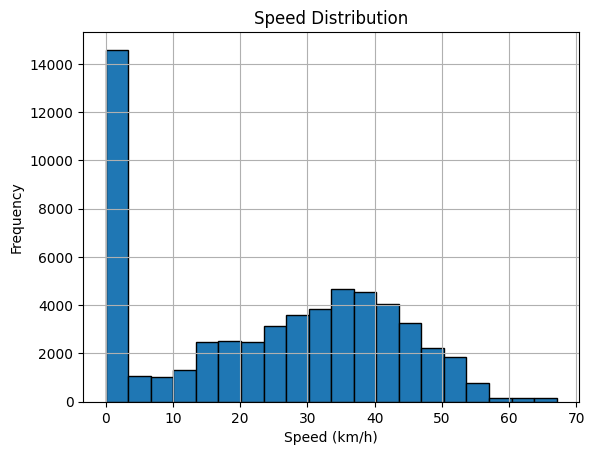

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
 
speeds = main_df_truncated_with_cell['speed']

plt.hist(speeds, bins=20, edgecolor='black')
plt.title("Speed Distribution")
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

## Calculate the free flow speed

In [80]:
import numpy as np
free_flow_threshold = 25 
free_flow_speeds = speeds[speeds > free_flow_threshold]

mean_speed = np.mean(free_flow_speeds)
percentile_85 = np.percentile(free_flow_speeds, 85)

print(f"Free Flow Speed (Mean): {mean_speed} km/h")
print(f"Free Flow Speed (85th Percentile): {percentile_85} km/h")


Free Flow Speed (Mean): 38.6741343770009 km/h
Free Flow Speed (85th Percentile): 47.86665 km/h


## Converting the free flow speed to m/s

In [81]:
percentile_85_m_s = percentile_85/3.6
ctm_params.free_flow_speed = percentile_85_m_s

# Grouping the data based on link_id, cell_id and time

In [82]:
grouped = duplicate_dropped.groupby(["closest_cell", "link_id", "time"])
vehicle_count = grouped.size().reset_index(name="vehicle_count")
vehicle_count["density"] = vehicle_count["vehicle_count"] / ctm_params.cell_length
vehicle_count

closest_cell  link_id    time  vehicle_count   density
0           cell_1        0  360.72              1  0.166667
1           cell_1        0  360.76              1  0.166667
2           cell_1        0  360.80              1  0.166667
3           cell_1        0  360.84              1  0.166667
4           cell_1        0  360.88              1  0.166667
...            ...      ...     ...            ...       ...
46174       cell_9        3  440.52              1  0.166667
46175       cell_9        4  427.04              1  0.166667
46176       cell_9        4  427.08              1  0.166667
46177       cell_9        4  427.12              1  0.166667
46178       cell_9        4  427.16              1  0.166667

[46179 rows x 5 columns]

In [83]:
vehicle_count["link_id"].unique()

array([0, 1, 2, 3, 4], dtype=int64)

# Testing the CTM model

In [86]:
def get_density_for_time(link_id, time, vehicle_count):
    t0 = time
    density_t0 = vehicle_count[(vehicle_count["link_id"] == link_id) & (vehicle_count["time"] == t0)]
    print("link_id", link_id, "time", time, "density_t0", density_t0, "\n")
    density_t0_initialized = segment_densities_predicted[link_id].copy()
    for index, row in density_t0.iterrows():
        density_t0_initialized[int(row["closest_cell"].split("_")[-1])-1] = row["density"]


    t1 = t0 + ctm_params.time_step


    density_t1 = vehicle_count[(vehicle_count["link_id"] == link_id) & (vehicle_count["time"] == t1)]
    density_t1_initialized = segment_densities_predicted[link_id].copy()
    for index, row in density_t1.iterrows():
        density_t1_initialized[int(row["closest_cell"].split("_")[-1])-1] = row["density"]
    density_t1_initialized = np.array(density_t1_initialized)
    density_t0_initialized = np.array(density_t0_initialized)
    # print("density_density_t0_initialized", density_t0_initialized, "density_t1_initialized", density_t1_initialized)
    return density_t0_initialized, density_t1_initialized
actual_values_dict = {}
predicted_values_dict = {}
rmses_dict = {}
times_dict = {}
predict_mean_dict = {}
actual_mean_dict = {}


for link_id in vehicle_count["link_id"].unique():
    rmses = []
    times = []
    predict_mean = []
    actual_mean = []
    predicted_values = []
    actual_values = []
    for unique_time in vehicle_count[vehicle_count["link_id"] == link_id]["time"].unique(): 
        density_t0_initialized, density_t1_initialized = get_density_for_time(link_id, unique_time, vehicle_count)
        inflow_dt = inflow[(inflow["time"] == unique_time) & (inflow["link_id"] == link_id)]
        if inflow_dt.empty:
            inflow_dt = 0
        else:
            inflow_dt = inflow_dt["inflow"].values[0]
        predicted_den = np.array(update_cell_status(unique_time, link_id, density_t0_initialized, ctm_params, inflow_dt, traffic_lights_df, traffic_lights_dict_states))
        predict_mean.append(predicted_den[:].mean())
        predicted_value = predicted_den[:]
        actual_value = density_t1_initialized[:]

        rmse = np.sqrt(np.mean((predicted_value - actual_value)**2))
        predicted_values.append(predicted_value)
        actual_values.append(actual_value)
        actual_mean.append(density_t0_initialized[:].mean())
        rmses.append(rmse)
        times.append(unique_time)
    actual_values_dict[link_id] = actual_values
    predicted_values_dict[link_id] = predicted_values
    rmses_dict[link_id] = rmses
    times_dict[link_id] = times
    predict_mean_dict[link_id] = predict_mean
    actual_mean_dict[link_id] = actual_mean

link_id 0 time 360.72 density_t0       closest_cell  link_id    time  vehicle_count   density
0           cell_1        0  360.72              1  0.166667
4958       cell_11        0  360.72              1  0.166667
8983       cell_13        0  360.72              1  0.166667
15152      cell_16        0  360.72              1  0.166667
27420       cell_3        0  360.72              1  0.166667
36406       cell_6        0  360.72              1  0.166667
38364       cell_7        0  360.72              1  0.166667 

link_id 0 time 360.76 density_t0       closest_cell  link_id    time  vehicle_count   density
1           cell_1        0  360.76              1  0.166667
4959       cell_11        0  360.76              1  0.166667
8984       cell_13        0  360.76              1  0.166667
10979      cell_14        0  360.76              1  0.166667
15153      cell_16        0  360.76              1  0.166667
27421       cell_3        0  360.76              1  0.166667
36407       cell_

# Plotting

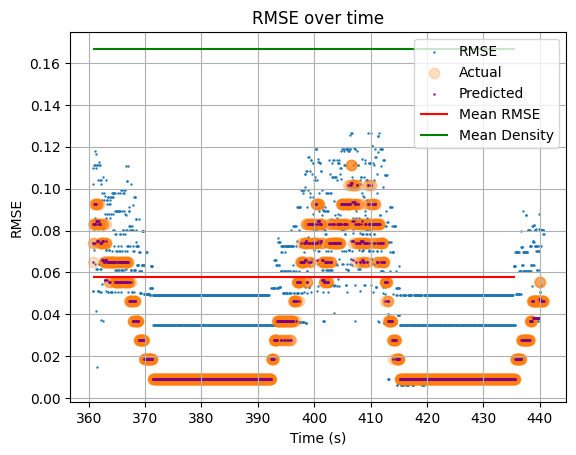

For link with id:  0  the RMSE is:  0.057756738281619625


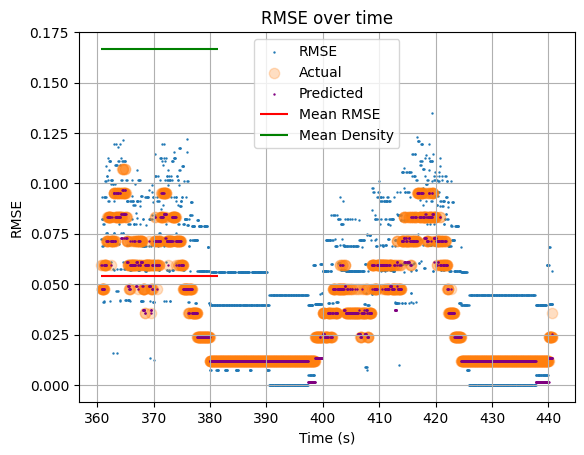

For link with id:  1  the RMSE is:  0.05425948579988885


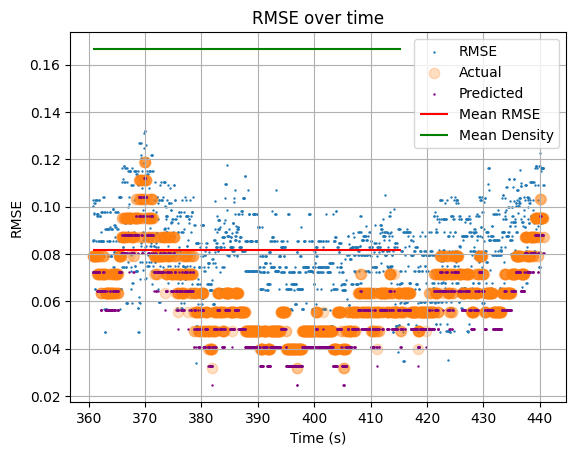

For link with id:  2  the RMSE is:  0.08182689313871865


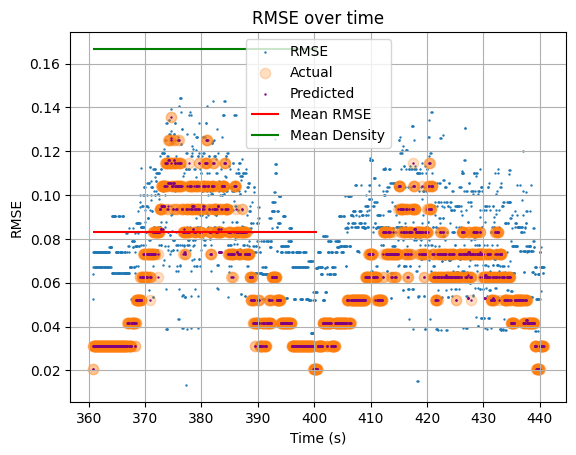

For link with id:  3  the RMSE is:  0.08318098601951428


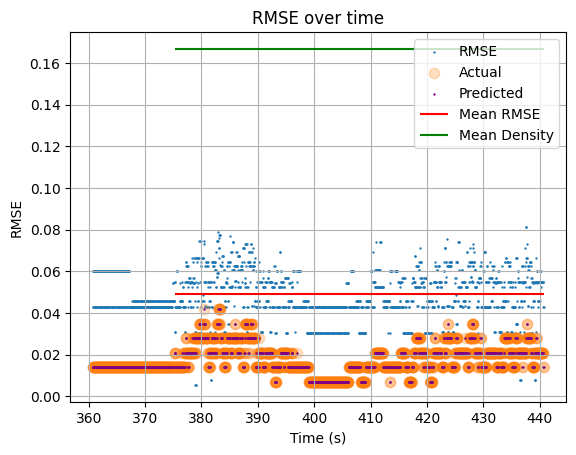

For link with id:  4  the RMSE is:  0.04906430003562902


In [87]:
for link_id in vehicle_count["link_id"].unique():
    times = times_dict[link_id]
    rmses = rmses_dict[link_id]
    predict_mean = predict_mean_dict[link_id]
    actual_mean = actual_mean_dict[link_id]
    
    plt.scatter(times[:], rmses[:], label="RMSE", s=0.5)
    plt.scatter(times[:], actual_mean[:], label="Actual", s=55, alpha=0.25)
    plt.scatter(times[:], predict_mean[:], label="Predicted", s=0.5, color="purple", alpha=1)
    plt.xlabel("Time (s)")
    plt.ylabel("RMSE")
    plt.title("RMSE over time")
    plt.hlines(np.mean(rmses), times[0], times[-1], label="Mean RMSE", color="red")
    plt.hlines(vehicle_count[vehicle_count["link_id"] == link_id].density.mean(), times[0], times[-1], label="Mean Density", color="green")
    plt.grid()
    plt.legend()
    plt.show()
    print("For link with id: ", link_id, " the RMSE is: ", np.mean(rmses))